In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

##### UNCOMMENT #####
# from google.colab import drive
# drive.mount('drive', force_remount=True)

Mounted at drive


# Chargement données

In [ ]:
# import re #Regular expressions operation

def readFile(filename):
    return [line.strip() for line in open(filename)]
#.decode("utf-8")

def readFileWithChunks(filename):
    lines_marked = [line.strip() for line in open(filename)]
    # .decode("utf-8")
    lines_clean1 = [line.replace('[ ', "") for line in lines_marked]
    lines_clean2 = [line.replace(' ]', "") for line in lines_clean1]
    return lines_clean2

In [ ]:
path_headline1_chunked = '/content/drive/MyDrive/CENTRALE MARSEILLE/3A/PSTALN/Projet PSTALN/Downloaded files/train_2015_10_22.utf-8/STSint.input.headlines.sent1.chunk.txt'
path_headline2_chunked = '/content/drive/MyDrive/CENTRALE MARSEILLE/3A/PSTALN/Projet PSTALN/Downloaded files/train_2015_10_22.utf-8/STSint.input.headlines.sent2.chunk.txt'
path_headline1 = '/content/drive/MyDrive/CENTRALE MARSEILLE/3A/PSTALN/Projet PSTALN/Downloaded files/train_2015_10_22.utf-8/STSint.input.headlines.sent1.txt'
path_headline2 = '/content/drive/MyDrive/CENTRALE MARSEILLE/3A/PSTALN/Projet PSTALN/Downloaded files/train_2015_10_22.utf-8/STSint.input.headlines.sent2.txt'


sent1_lines = readFileWithChunks(path_headline1_chunked)
sent2_lines = readFileWithChunks(path_headline2_chunked)
sent1_lines_chunked = readFile(path_headline1_chunked)
sent2_lines_chunked = readFile(path_headline2_chunked)

Train Test split

In [ ]:
trainSamples = sent1_lines
trainSamplesChunked = sent1_lines_chunked

testSamples = sent2_lines
testSamplesChunked = sent2_lines_chunked

print('Train size:', len(trainSamples))
print('Test size:', len(testSamples))

Train size: 756
Test size: 756


# Embeddings

Chargement d'Embeddings préentrainés de type GloVe pour obtenir des représentation des mots de notre dataset

Inspiré de : https://keras.io/examples/nlp/pretrained_word_embeddings/

In [ ]:
#On suppose que l'embedding est disponible (voire préentrainé si possible) : cf Mouss

import numpy as np
import tensorflow as tf
from tensorflow import keras

Creation vocabulaire indexes

In [ ]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(trainSamples).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'in', 'to', 'on']

In [ ]:
output = vectorizer([["the cat sat on the mat"]])
output.numpy()[0, :6]
#Dans cette phrase test : 3 mots ne font pas partie du voc de notre db et sont donc '<UNK>'

array([17,  1,  1,  4, 17,  1])

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

Download GloVe embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-01-12 18:16:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-12 18:16:50--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-12 18:16:50--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
path_to_glove_file = '/content/glove.6B.100d.txt'

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 2075 words (58 misses)


# Chunking

#### Preprocessing

> y_train / y_test

In [ ]:
nbClasses = 3 #3 pourBIO

##### Y - BIO Encoding

In [ ]:
def removeNoise(line):
    noiseTokens = ['[', ']', ',', '.', ':', ';', '"', "'", "''", "`", "-",]
    for token in noiseTokens:
      line = line.replace(token, "")
    return line


def chunkedLine2ListChunks(line):
  line = removeNoise(line)
  line = line.split('  ')
  for chunk in line:
    if len(chunk)==0: 
      while chunk in line:
        del line[line.index(chunk)]
  return line


def isInsideChunk(word, chunk):
  """
  Returns True if word have to be encoded as a O (BIO)
  Else False
  """
  return word in chunk

# ex = sent1_lines_chunked[0]
# l = chunkedLine2ListChunks(ex)
# print("Nazi" in l[0])
# print(isInsideChunk("Nazi", l[0]))


def isFirstChunkWord(word, chunk):
  """
  On suppose que le mot est présent dans le chunk

  Returns True if word have to be encoded as a B (BIO)
  Else False if word have to be encoded as a I (BIO)
  """
  chunk = chunk.split()
  return chunk[0] == word

# isFirstChunkWord("Nazi", l[0])

def wordBIOencoding(word, chunk):
  if isInsideChunk(word, chunk):
    if isFirstChunkWord(word, chunk): return 'B'
    else : return 'I'
  else : return 'O'

def sentenceBIOencoding(line, chunkedLine):
  '''
  La pertinence du 'O' n'est pas évidente ici étant donné que tous les mots de line semblent faire partie d'un chunk de chunkedLine
  '''

  words = line.split()
  chunks = chunkedLine2ListChunks(chunkedLine)
  BIOcodes = []

  currentChunk = 0

  for word in words:
    code = wordBIOencoding(word, chunks[currentChunk])

    if code == 'O':
      if currentChunk+1<len(chunks):
        currentChunk+=1 #Attention on explore le chunk suivant (si jamais c'est le début d'un autre chunk)
        test_code = wordBIOencoding(word, chunks[currentChunk])
        if test_code == 'B':
          code = test_code

    BIOcodes.append(code)
  return BIOcodes


# for idx in range(3):
#   ex = sent1_lines_chunked[idx]
#   print(ex)
#   l = chunkedLine2ListChunks(ex)
#   print(l)
#   print()


# nbSamples = 3 #len(sent1_lines)
# for line, chunkedLine in zip(sent1_lines[:nbSamples], sent1_lines_chunked[:nbSamples]):
#   BIOcodes = sentenceBIOencoding(line, chunkedLine)
#   print(line.split())
#   print(BIOcodes)
#   print(chunkedLine)
#   print()

In [ ]:
BIO_y_train = []  #Contains BIO codes
BIO_y_test = []

nbSamples = len(trainSamples)
for line, chunkedLine in zip(trainSamples[:nbSamples], trainSamplesChunked[:nbSamples]):
    BIOcodes = sentenceBIOencoding(line, chunkedLine)
    BIO_y_train.append(BIOcodes)

nbSamples = len(testSamples)
for line, chunkedLine in zip(testSamples[:nbSamples], testSamplesChunked[:nbSamples]):
    BIOcodes = sentenceBIOencoding(line, chunkedLine)
    BIO_y_test.append(BIOcodes)

print(len(trainSamples), len(BIO_y_train))
print(trainSamplesChunked[0])
print(BIO_y_train[0])

756 756
[ Former Nazi death camp guard Demjanjuk ] [ dead ] [ at 91 ]
['B', 'I', 'I', 'I', 'I', 'I', 'B', 'B', 'I']


##### Y - Conversion caractères BIO en entiers

In [ ]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
labelEncoder.fit(['B', 'I', 'O'])
print(labelEncoder.transform(['B', 'I', 'O']))

[0 1 2]


In [ ]:
BIO_int_y_train = []
BIO_int_y_test = []

for line in BIO_y_train:
  BIO_int_y_train.append(labelEncoder.transform(np.array(line)))

for line in BIO_y_test:
  BIO_int_y_test.append(labelEncoder.transform(np.array(line)))

print(trainSamplesChunked[0])
print(BIO_y_train[0])
print(BIO_int_y_train[0])

[ Former Nazi death camp guard Demjanjuk ] [ dead ] [ at 91 ]
['B', 'I', 'I', 'I', 'I', 'I', 'B', 'B', 'I']
[0 1 1 1 1 1 0 0 1]


##### Y - Conservion One Hot 

In [ ]:
from keras.utils import np_utils

y_train = []  #One hot encoded
y_test = []

for line in BIO_int_y_train:
  y_train.append(np_utils.to_categorical(line, num_classes=nbClasses))

for line in BIO_int_y_test:
  y_test.append(np_utils.to_categorical(line, num_classes=nbClasses))

print(trainSamplesChunked[0])
print(BIO_y_train[0])
print(BIO_int_y_train[0])
print(y_train[0])

[ Former Nazi death camp guard Demjanjuk ] [ dead ] [ at 91 ]
['B', 'I', 'I', 'I', 'I', 'I', 'B', 'B', 'I']
[0 1 1 1 1 1 0 0 1]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


##### X - Conversion format input

In [ ]:
def preprocessLines(lines):
  return np.array(vectorizer(np.array([[s] for s in lines])))

x_train = preprocessLines(trainSamples)
x_test = preprocessLines(testSamples)

print(x_train.shape)
print(x_test.shape)

(756, 200)
(756, 200)


##### Y - Conversion format input

> On complète le nombre de prédictions attendues pour en avoir le même nombre que de môts dans un sample de X (paddings INCLUS)

In [ ]:
predictionForPaddingWord = [0, 0, 2]  # = 'O'
lenSentence = x_train.shape[1]

def completeLineLabels(lineLabels, lenSentence):
  '''
  Add 'O' labels for Padding words
  '''
  nbWordsInSample = len(lineLabels)
  nbPaddingLabelsToAdd = lenSentence-nbWordsInSample

  paddingLabels = np.array([predictionForPaddingWord for i in range(nbPaddingLabelsToAdd)])
  lineLabels = np.concatenate((lineLabels,paddingLabels))

  return lineLabels

#Test
y = np.array(completeLineLabels(y_train[0], 200))
print(y.shape)

(200, 3)


In [ ]:
y_train = np.array([np.array(completeLineLabels(line_labels, lenSentence)) for line_labels in y_train])
y_test = np.array([np.array(completeLineLabels(line_labels, lenSentence)) for line_labels in y_test])

print(y_train.shape)
print("Sample size", y_train[0].shape)

(756, 200, 3)
Sample size (200, 3)


#### Modèle tagging : Simple RNN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Embedding, Input

# SimpleRNN model
model = Sequential()
model.add(Input(shape=(None,), dtype="int64"))
model.add(Embedding(
    input_dim=num_tokens, #Size of the vocabulary
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False #Don't want to update embeddings
                    ))
model.add(SimpleRNN(units=nbClasses, #dim hidden state returned
                    activation="softmax", 
                    return_sequences=True
                    )) #return_sequences=False pour obtenir uniquement la derniere couche RNN

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         213500    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 3)           312       
                                                                 
Total params: 213,812
Trainable params: 312
Non-trainable params: 213,500
_________________________________________________________________


Entrainement

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

history = model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=2, validation_data=(x_test, y_test), callbacks=[callback])

Epoch 1/50
24/24 - 3s - loss: 2.0783 - acc: 0.0136 - val_loss: 2.0102 - val_acc: 0.0170 - 3s/epoch - 110ms/step
Epoch 2/50
24/24 - 1s - loss: 1.9605 - acc: 0.0203 - val_loss: 1.9057 - val_acc: 0.0245 - 1s/epoch - 48ms/step
Epoch 3/50
24/24 - 1s - loss: 1.8592 - acc: 0.6969 - val_loss: 1.8079 - val_acc: 0.9801 - 1s/epoch - 49ms/step
Epoch 4/50
24/24 - 1s - loss: 1.7632 - acc: 0.9818 - val_loss: 1.7143 - val_acc: 0.9813 - 1s/epoch - 48ms/step
Epoch 5/50
24/24 - 1s - loss: 1.6710 - acc: 0.9831 - val_loss: 1.6243 - val_acc: 0.9819 - 1s/epoch - 48ms/step
Epoch 6/50
24/24 - 1s - loss: 1.5823 - acc: 0.9840 - val_loss: 1.5377 - val_acc: 0.9827 - 1s/epoch - 48ms/step
Epoch 7/50
24/24 - 1s - loss: 1.4968 - acc: 0.9848 - val_loss: 1.4542 - val_acc: 0.9831 - 1s/epoch - 48ms/step
Epoch 8/50
24/24 - 1s - loss: 1.4145 - acc: 0.9853 - val_loss: 1.3739 - val_acc: 0.9833 - 1s/epoch - 49ms/step
Epoch 9/50
24/24 - 1s - loss: 1.3354 - acc: 0.9855 - val_loss: 1.2967 - val_acc: 0.9834 - 1s/epoch - 48ms/step


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


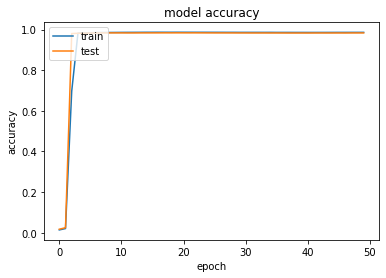

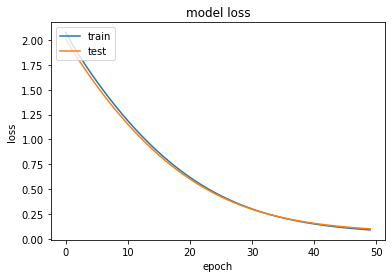

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Remarque:** Il nous faudrait probablement moins entrainer le modèle afin qu'il se préoccupe moins de la prédiction des paddings en fin de phrase.

La moindre prise en compte des paddings en fin de phrase par le modèle est un des problèmes à résoudre ici si l'on souhaite améliorer les performances de ce modèle baseline.

#### 📌 Construction de phrases 'chunkées' à partir de phrases non-chunkées

In [ ]:
def startChunk(word):
  return '[ ' + word

def endChunk(word):
  return word + ' ]'

def chunkLine(line, line_labels_integers, showErrors):

  new_line = line.split()
  previous_label = -1

  i = -1
  for word, label in zip(
                        line.split(),
                        line_labels_integers[:len(line.split())]
                        ):
    i +=1
    if label == 0:  #"B"
      new_line[i] = startChunk(word)
      if previous_label == 1 or previous_label == 0:
        new_line[i-1] = endChunk(new_line[i-1])
      previous_label = 0

    if label == 2:  #'O'
      if previous_label == 0 or previous_label== 1:
        new_line[i-1] = endChunk(new_line[i-1])
      previous_label = 2

    if label == 1 : #'I'
      if previous_label == 2: 
        if showErrors : print(f"Oups il y a eu une erreur de classification du mot '{word}' dans la phrase \n {line}\n")
      if previous_label == -1:  #Problème de prédiction d'un I en début de phrase pour des noms propres ...
        if showErrors : print(f"Erreur début de phrase : '{word}'\n {line}\n")
        new_line[i] = startChunk(word) 
      previous_label = 1

    if i == len(line.split()) - 1:  #Fin de phrase
      if label == 0 or label == 1: # 'B' ou 'I'
        new_line[i] = endChunk(word)
    
  separator = ' '
  new_line = separator.join(new_line)
  return new_line

def chunkDataset(lines, showErrors=False):

  #Preprocess 'lines' pour prédictions
  x= preprocessLines(lines)

  y_pred = model.predict(x)
  lines_labels_integers = np.argmax(y_pred, axis=2)

  chunkedLines = []

  for line, line_labels_integers in zip(lines, lines_labels_integers):
    chunkedLines.append(chunkLine(line, line_labels_integers, showErrors))

  return chunkedLines

In [ ]:
chunkedLines = chunkDataset(testSamples, showErrors=False)
nb = 3

#Pour affichage uniquement
x= preprocessLines(testSamples)
y_pred = model.predict(x)
lines_labels_integers = np.argmax(y_pred, axis=2)

for line, trueChunkedLine, chunkedLine, lineLabels in zip(testSamples[:nb], testSamplesChunked[:nb], chunkedLines[:nb], lines_labels_integers[:nb]):
  print('Line : \t\t\t\t', line)
  print('True chunked line : \t\t', trueChunkedLine)
  print('Predicted chunked line : \t', chunkedLine)
  print('Predicted labels : \t\t', lineLabels[:len(line.split())])
  print()

Line : 				 John Demjanjuk , convicted Nazi death camp guard , dies aged 91
True chunked line : 		 [ John Demjanjuk ] [ , ] [ convicted Nazi death camp guard ] [ , ] [ dies ] [ aged 91 ]
Predicted chunked line : 	 [ John ] Demjanjuk [ , convicted ] [ Nazi death camp ] [ guard ] , dies aged 91
Predicted labels : 		 [0 2 0 1 0 1 1 0 2 2 2 2]

Line : 				 Saudi Women Allowed To Compete At Olympics
True chunked line : 		 [ Saudi Women ] [ Allowed ] [ To Compete ] [ At Olympics ]
Predicted chunked line : 	 [ Saudi Women ] Allowed [ To ] [ Compete ] [ At Olympics ]
Predicted labels : 		 [0 1 2 0 0 0 1]

Line : 				 Drone strike kills four suspected militants in Pakistan
True chunked line : 		 [ Drone strike ] [ kills ] [ four suspected militants ] [ in Pakistan ]
Predicted chunked line : 	 [ Drone strike ] [ kills ] [ four ] [ suspected ] [ militants ] [ in Pakistan ]
Predicted labels : 		 [0 1 0 0 0 0 0 1]



#### Evaluation

##### Evaluation par label

In [ ]:
def getBatchAccuracy(y_pred, y_true):
  '''
  Input
  -----
  Batch labels hot encoded of dimension batch_size x 200 x 3
  '''
  assert len(y_pred.shape) == len(y_true.shape) == 3 

  sum_acc = 0
  for i in range(len(y_pred)):
    sum_acc += getSampleAccuracy(y_pred[i], y_true[i])  #Attention ici on ne défini pas une prédiction de chunking de phrase uniquement comme correcte ou non, mais possiblement partiellement correcte
  return sum_acc / len(y_pred)


def getSampleAccuracy(y_sample_pred, y_sample_true):
  '''
  Input
  -----
  Sentence/Sample labels hot encoded of dimension 200 x 3
  '''
  # assert len(y_sample_pred.shape) == len(y_sample_true.shape) == 2

  pred_labels_integers = np.argmax(y_sample_pred, axis=1)
  true_labels_integers = np.argmax(y_sample_true, axis=1)

  true_counts = 0
  insideSentence = False
  lenSentence = 0
  for i in range(len(pred_labels_integers)-1, -1, -1):

    #On ne prend pas en compte les paddings àjoutés à la fin des phrases pour le calcul du score
    if (true_labels_integers[i] != 2) and not(insideSentence):
      insideSentence = True

    if insideSentence: lenSentence += 1
    if true_labels_integers[i] == pred_labels_integers[i] and insideSentence:
      true_counts +=1
  
  # if lenSentence !=0 : print(pred_labels_integers)
  return true_counts/(lenSentence+1)

In [ ]:
y_pred = model.predict(x_train)

acc = getBatchAccuracy(y_pred=y_pred, y_true=y_train)
print(acc)

0.5713044275164956


In [ ]:
y_pred = model.predict(x_test)

acc = getBatchAccuracy(y_pred=y_pred, y_true=y_test)
print(acc)

0.5124096600783107


##### Evaluation par chunk

Méthode retenue pour la comparaison avec le modèle state of the art.

Cette méthode est à nuancer car on considère ici qu'un chunck est soit bon soit faut (et non pas partiellement bon).

In [ ]:
def chunking_score(output_chunks, gold_chunks):
    score = 0
    for i in range(len(output_chunks)):
        sent_score = 0
        for chk in output_chunks[i]:
            if chk in gold_chunks[i]:
                sent_score += 1
        score += sent_score/len(gold_chunks[i])
    return score/len(output_chunks)

In [ ]:
def removeWordsOutOfChunks(line):
  new_line = []

  c = ''  #current chunk
  insideChunk = False

  for char in line:

    if char == ']': 
      insideChunk = False
      new_line.append(c.strip())
      c = ''

    if insideChunk : c += char

    if char == '[': 
      insideChunk = True


  return new_line

In [ ]:
output_chunks = []
gold_chunks = []
for true_line, line in zip(testSamplesChunked, chunkedLines):
  ## Filtrage des mots : Suppression des mots prédis comme hors des chunks (pour fit la méthode d'évaluation proposée)
  newLine = removeWordsOutOfChunks(line)

  #Transformation phrase chuckée en liste de chunks
  # newLine déja au bon format
  gold_chunk = true_line.strip("[ ").strip(" ]").split(" ] [ ")

  output_chunks.append(newLine)
  gold_chunks.append(gold_chunk)

#Calculer score
chunking_score(output_chunks, gold_chunks)


0.37132096665826797

# Alignement

### Définition des méthodes

In [ ]:
from math import *
from scipy.optimize import linear_sum_assignment

def norm(x):
    norm=0
    for elt in x:
        norm+=elt**2
    norm=sqrt(norm)
    return(norm)

def similarity(x,y):
    '''
    Cosine Similarity
    '''
    sim=np.dot(x, y)
    sim=sim/(norm(x)*norm(y))
    return(sim)

Méthode d'alignement : Hungarian Algorithm (a.k.a. the Kuhn-Munkres algorithm)

In [ ]:
def alignment_chunks(sentence_1, sentence_2):
    '''
    Hungarian Algorithm : aligner chunks pour meilleur score possible de phrase 

    Idea for improvement : 
    Normalize chunk similarity by number of tokens in shorter chunk 
    such that it assigned higher scores to pairs of chunks such as physician and general physician.
    '''
    cost=[]
    if len(sentence_2)<len(sentence_1): ##If more rows than columns, not every row needs to be assigned to a column, and vice versa.
        s1, s2 = sentence_2, sentence_1 #Always select shorter sentence as first sentence !
        inv=True
    else:
        s1, s2=sentence_1, sentence_2
        inv=False

    for i in range (len(s1)):
        inter=[]
        for j in range(len(s2)):
            sim=alignment_mots(s1[i], s2[j])        
            inter.append(sim)
        cost.append(inter)
    cost=np.array(cost)

    row_ind, col_ind = linear_sum_assignment(-cost) # - car linear_sum_assignment minimise normalement
    
    #Liste de score de similarité pour chaque alignement optimal de chunks
    sim=cost[row_ind, col_ind]
    sim=min_max_scaler(sim)

    if inv:
        row_ind, col_ind=col_ind, row_ind

    list_couples_chunks_et_score=[]
    for i in range(len(sim)):
        list_couples_chunks_et_score.append((row_ind[i], col_ind[i], sim[i]))

    return(list_couples_chunks_et_score)


def alignment_mots(chunk_1, chunk_2):
    '''
    Hungarian Algorithm sur 2 chunks : aligner mots pour meilleur score possible
    '''
    if len(chunk_2)<len(chunk_1): ##If more rows than columns, not every row needs to be assigned to a column, and vice versa.
        c1, c2 = chunk_2, chunk_1 #Always select shorter sentence as first sentence !
    else:
        c1, c2 = chunk_1, chunk_2
    cost=[]
    for i in range (len(c1)):
        inter=[]
        for j in range(len(c2)):
            inter.append(similarity(c1[i], c2[j]))
        cost.append(inter)
    cost=np.array(cost)

    # print(cost.shape)
    # print(chunk_1, chunk_2)
    # print()

    #col_ind, #col_ind donne alignement des mots pour obtenir meilleur score de similarité possible
    row_ind, col_ind = linear_sum_assignment(-cost) #- car linear_sum_assignment minimise normalement
    
    #score de similarité entre 2 chunks
    sim=cost[row_ind, col_ind].sum()

    return(sim)
 

def min_max_scaler(sim):
    scaled=[]
    a, b = 3, 1 #On remarque que les scores non scalés sont tous entre 1 et 3 #np.max(sim), np.min(sim) 
    
    for elt in sim:
        inter = (elt-b)/(a-b)
        inter = inter*5 #Pour avoir des scores entre 0 et 5
        inter = round(inter) #Pour avoir des scores entiers
        scaled.append(inter)
    return(scaled)

In [ ]:
def create_list_of_embedded_chunks_exploitable_for_alignement(chunked_sentence):
  chunk=''

  list_sentence=[]
  for i in range(len(chunked_sentence)):
    elt = chunked_sentence[i]
    if elt!='[' or elt !=']' or elt!=' ':
      chunk += elt
    if elt==']':
      chunk = removeNoise(chunk)
      list_sentence.append(chunk)
      chunk = ''

  list_sentence_embedded=[]
  for elt in list_sentence:
    inter = elt.split(' ')
    inter_copy=inter[:] #inter without '

    for elt_bis in inter_copy:
      if elt_bis=='':
        inter_copy.remove(elt_bis)

    inter_embedded=[]
    for elt_ter in inter_copy:
      elt = vectorizer(elt_ter)
      elt = elt.numpy()
      elt = list(elt)
      if len(elt)!=0:
        inter_embedded.append(elt)

    list_sentence_embedded.append(inter_embedded)

  return(list_sentence_embedded)

### Tests préliminaires performance algo

**Remarque:** Notre algorithme d'alignement de chunks ne fonctionne pas pour certaines phrases et nous n'avons pas trouvé d'explications à celà pour le moment.

> Calcul de la proportion de combinaisons de phrases renvoyant un message d'erreur en prenant les 10 premières phrases du corpus.

In [ ]:
n= 10#len(testSamplesChunked)

n_failed=0

for i in range(n-1):
  for j in range(i+1,n):
    try:

      sentence_1=testSamplesChunked[i]
      sentence_2=testSamplesChunked[j]

      sentence_a=create_list_of_embedded_chunks_exploitable_for_alignement(sentence_1)
      sentence_b=create_list_of_embedded_chunks_exploitable_for_alignement(sentence_2)

      print(alignment_chunks(sentence_a, sentence_b))
    except:
      n_failed+=1
      pass

nb_couples=n*(n+1)*0.5
print(n_failed/nb_couples) #Proportions de combinaisons ne fonctionnant pas m

[(0, 3, 2), (1, 1, 0), (2, 0, 2), (3, 2, 2)]
[(3, 0, 2), (2, 1, 0), (0, 2, 2)]
[(0, 4, 2), (1, 2, 0), (2, 3, 2), (3, 1, 0)]
[(0, 3, 2), (1, 2, 0), (2, 0, 2), (3, 1, 0)]
[(0, 3, 2), (1, 2, 0), (2, 1, 0), (3, 0, 0)]
[(3, 0, 2), (1, 1, 0), (2, 2, 5)]
[(0, 4, 2), (1, 2, 0), (2, 3, 5), (3, 1, 0)]
[(0, 3, 2), (1, 2, 0), (2, 0, 2), (3, 1, 0)]
[(0, 1, 0), (1, 2, 0), (2, 3, 5), (3, 0, 0)]
[(0, 4, 2), (1, 2, 0), (2, 3, 5)]
[(0, 3, 2), (1, 2, 0), (2, 0, 2)]
[(0, 1, 0), (1, 2, 0), (2, 3, 5)]
[(4, 0, 2), (1, 1, 0), (2, 2, 0), (3, 3, 2)]
[(4, 0, 0), (1, 1, 0), (2, 2, 0), (3, 3, 5)]
[(0, 3, 2), (1, 2, 0), (2, 1, 0), (3, 0, 0)]
0.5454545454545454


Recherche des chunks alignés avec des scores de similarités égaux à 5 pour étudier les performances de notre modèle

In [ ]:
n= 100#len(testSamplesChunked)

n_failed=0
list_best_scores=[]

for i in range(1,n-1):
  for j in range(i+1,n):
    try:

      sentence_1=testSamplesChunked[i]
      sentence_2=testSamplesChunked[j]

      sentence_a=create_list_of_embedded_chunks_exploitable_for_alignement(sentence_1)
      sentence_b=create_list_of_embedded_chunks_exploitable_for_alignement(sentence_2)

      for elt in alignment_chunks(sentence_a, sentence_b)[:][2]:
        if elt==5:
          list_best_scores.append((i,j))

      #print(alignment_chunks(sentence_a, sentence_b), (i,j))
    except:
      n_failed+=1
      pass

In [ ]:
for (i,j) in list_best_scores:
    sentence_1=testSamplesChunked[i]
    sentence_2=testSamplesChunked[j]

    sentence_a=create_list_of_embedded_chunks_exploitable_for_alignement(sentence_1)
    sentence_b=create_list_of_embedded_chunks_exploitable_for_alignement(sentence_2)

    print(alignment_chunks(sentence_a, sentence_b))
    print(sentence_1)
    print(sentence_2)

### Script

Alignement sur les gold chunks

In [ ]:
dataset1_chunked = trainSamplesChunked
dataset2_chunked = testSamplesChunked

alignements_gold = []
for S1, S2 in zip(dataset1_chunked, dataset2_chunked): 

  #Preprocess
  s1 = create_list_of_embedded_chunks_exploitable_for_alignement(S1)
  s2 = create_list_of_embedded_chunks_exploitable_for_alignement(S2)

  print(s1)
  print(s2)

  score_line = alignment_chunks(s1, s2)
  alignements_gold.append(score_line)

#alignements_gold

[[[259, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1291, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

ValueError: ignored

Alignement sur les chunks prédits

In [ ]:
chunkedLines1 = chunkDataset(trainSamples, showErrors=False)
chunkedLines2 = chunkDataset(testSamples, showErrors=False)

alignements_pred = []
for S1, S2 in zip (chunkedLines1, chunkedLines2): 

  # Suppression des mots hors des chunks avant alignement
  s1 = removeWordsOutOfChunks(S1)
  s2 = removeWordsOutOfChunks(S2)

  #Preprocess
  s1 = create_list_of_embedded_chunks_exploitable_for_alignement(s1)
  s2 = create_list_of_embedded_chunks_exploitable_for_alignement(s2)

  score_line = alignment_chunks(s1, s2)
  alignements_pred.append(score_line)

# alignements_pred

ValueError: ignored

On crée une fonction permettant de mettre les résultats de l'alignement des segments sous forme d'un fichier .wa

In [ ]:
def enumerate_word_with_indexe(sentence):
  list_words=[]
  a=sentence.split(']')
  counter=1
  for i in range(len(a)):
    b=a[i]
    b=b.replace('[','')
    indices=[]
    for elt in b.split():
      print(counter,'', elt)
      indices.append(counter)
      counter+=1
    list_words.append(b.split()+[indices])
  return(list_words)

sentence_1=testSamplesChunked[1]
sentence_2=testSamplesChunked[2]

sentence_a=create_list_of_embedded_chunks_exploitable_for_alignement(sentence_1)
sentence_b=create_list_of_embedded_chunks_exploitable_for_alignement(sentence_2)

str_liste_indices_token_chunk1, str_liste_indices_token_chunk2, scores=[], [], []
for elt in alignment_chunks(sentence_a, sentence_b):
  str_liste_indices_token_chunk1.append(elt[0])
  str_liste_indices_token_chunk2.append(elt[1])
  scores.append(elt[2])

In [ ]:
#def format_wa(path_to_write, chunked_sentence1, chunked_sentence2):
print('<sentence id="' + str(id) + '" status="">')
print('// ' + sentence1)
print('// ' + sentence2)
print('<source>')
chunks1=enumerate_word_with_indexe(sentence_1)
print('</source>')
print('<translation>')
chunks2=enumerate_word_with_indexe(sentence_2)
print('</translation>')
print('<alignment>')
for i in range(len(scores)): 
  a, b=str_liste_indices_token_chunk1[i], str_liste_indices_token_chunk2[i]
  print(str(chunks1[a][-1]) + ' <==> ' + str(chunks2[b][-1])
      + ' // EQUI // ' + str(scores[i]) + ' // ' + str(chunks1[a][:-1]) + ' <==> ' + str(chunks2[b][:-1]))
print('</alignment>')
print('</sentence>')